## Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Parameters

In [2]:
N = 100 # Number of individuals per sample group
k = 20 # Number of sample groups
r = 2 # Number of latent variables
# Let M be a k x r x N matrix, where M[a,b,c] represents the ath sample group's bth trait for the ath person.
M = np.zeros((k,r,N))

## Data Generation

In [3]:
# We must also define distribution functions for each sample group.
# For the sake of this experiment, let the two distribution functions be g and h.
# g is a normal distribution with mean = g_mean, stdev = g_stdev.
# f is a lognormal distribution with mean = f_mean, stdev = f_stdev.
# Let the means and stdevs be randomly selected from a linear distribution.
# The coefficients are hardcoded

g_mean = 1 - 2*np.random.random(k)
g_stdev = 0.5*np.random.random(k)
f_mean = 2*np.random.random(k)
f_stdev = 0.3*np.random.random(k)

# Now populate M with the appropriate variables.
mean_a = np.zeros(20)
mean_b = np.zeros(20)

median_a = np.zeros(20)
median_b = np.zeros(20)

for i in range(k):
    M[i,0,:] = np.random.normal(g_mean[i], g_stdev[i], N)
    M[i,1,:] = np.random.lognormal(f_mean[i], f_stdev[i], N)
    mean_a[i] = np.mean(M[i,0,:])
    mean_b[i] = np.mean(M[i,1,:])
    median_a[i] = np.median(M[i,0,:])
    median_b[i] = np.median(M[i,1,:])

In [4]:
# We define a mapping of the latent variables (x,y) to a single value, w. 
# This is hard-coded for now, but these parameters can easily be changed by modifying this funciton.
# We also set the default parameter "z" to be 0. This is for the intervention, which will add an
# additional parameter 'z' to the individuals. 
# Note that f(x,y,0) = f(x,y).
def calculateW(x,y,z=0):
    coef_x = 0.8
    coef_y = 0.2
    coef_z = 0.5
    return coef_x * x + coef_y + y + coef_z * z

In [5]:
# Now, we must define a mapping of the latent variables (x,y) to a single value, w.
# Let us hard-code this mapping as a linear combination of x and y.
# Also define M_prime, a k x N matrix where M[a,b] represents the ath sample group's bth individual's value.

M_prime = np.zeros((k,N))
for i in range(k):
    for j in range(N):
        M_prime[i,j] = calculateW(M[i,0,j], M[i,1,j])

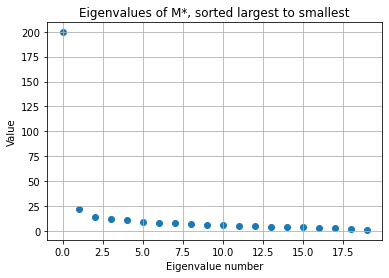

In [7]:
# Let us first verify that this matrix is low rank. 

U, S, V = np.linalg.svd(M_prime)
X = np.arange(20)
plt.title("Eigenvalues of M*, sorted largest to smallest")
plt.xlabel("Eigenvalue number")
plt.ylabel("Value")
plt.scatter(X,S)
plt.grid()
plt.show()

## Intervention & Time increment

In [8]:
# Now we define a new matrix, M2, such that M2 represents the state of the individuals
# after an intervention. We assume that there is no spillover, i.e. M[1:,:] is 
# mostly unchanged, which will be represented by a small addition of noise.
# On the other hand, M[0,:] will now be redefined as values for f(x,y,z), with
# newly generated values for z representing the intervention.


# The intervention variables will be sampled from a Gaussian (arbitrary) with mean = -1, stddev = 0.2
intervention_mean = -1
intervention_stdev = 0.2
intervention = np.random.normal(intervention_mean, intervention_stdev, N)

# Define new matrix M2
M2 = np.zeros((k,N))

# First row is target (WLOG), and we set its value appropriately.
for idx in range(N):
    M2[0,idx] = calculateW(M[0,0,idx],M[0,1,idx],intervention[idx])

# Copy over rows from M_prime for 1 <= idx <= N, and add noise.
# Gaussian for this noise has mean = 0, stddev = 0.05.
for idx in range(1,k):
    M2[idx,:] = M_prime[idx,:] + np.random.normal(0,0.05,N)

## Visualize Data